# GPT2 Implementation 
- Code References: 
    - OpenAI Github: https://github.com/openai/gpt-2  
    - GPT2 Pytorch: https://github.com/graykode/gpt-2-Pytorch/tree/master/GPT2

## 1.Model
- Language Models 
    - Attention: seq2seq + Attention mechanism 
        - Machine Translation
    - Transformer: Only Attention (without RNN)
        - Encoder + Decoder stack  
        - Encoder: Self-Attention --> Feed Forward NN
        - Decoder: *Masked Self-Attention* --> Encoder-Decoder Self-Attention --> Feed Forward NN 
    - BERT: 
        - Only Transformer's Encoder stack 
        - Not auto-regressive: fully consider contextual information  
    - GPT2: 
        - Only Transformer's Decoder stack
        - **Maksed Self-Attention** (difference between BERT & GPT2)
        - auto-regressive: better next word prediction, BUT can't use (t+1) timeline's words in the context   

- Model Architecture 
    - BPE (Byte Pair Encoding): split subwords  
        - GPT2 uses tokens through BPE for input 
        - 빈도 수에 따라 문자를 병합하여 서브워드 구성 
        - 단어를 문자(char) 단위로 쪼갠 뒤 가장 빈도수 높은 쌍을 하나로 통합하는 과정 반복하여 Token Dictionary 생성 
    - Positional Encoding: 
        - Input token = embedded token + POSITIONAL ENCODING 
        - No RNN --> No sequential information, SO Positional Encoding adds sequential(positional) information 
    - Maksed Self-Attention:
        - Attention: consider contextual information (해당 단어가 무슨 단어와 가장 연관 있는지; linear relationship)   
    - Model Output = Max_Prob(output vectors * Token Embedding vector)
        - output vectors: after through all Decoder blocks --> have final self-attention score about input 
        - output vectors * Token embedding vectors = Prob of each word to become next word  
        - finally, each final output become next time_step's input 

In [33]:
# import modules
import numpy as np
import torch 
import tensorflow as tf
import math
import torch.nn as nn
from torch.nn.parameter import Parameter 

In [34]:
# from tensorflow.contrib.training import Haparams <-- Not available in tf v2 
## replace with torch Parameter functions 
def default_hparams():
    return Parameter(
        n_vocab=0,
        n_ctx=1024,
        n_embd=768,
        n_head=12,
        n_layer=12 )

def shape_list(x):
    # Deal with dynamic shape in tensorflow cleanly.
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

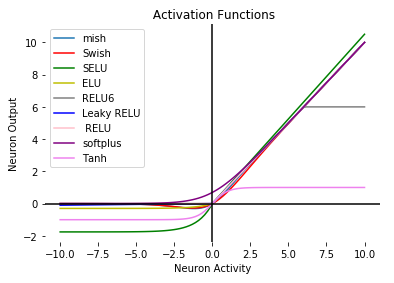

In [35]:
# Activatiion functions 
from IPython.display import Image
from PIL import Image
Image.open("C:\\Users\\user\\OneDrive\\사진\\activation_functions.png")

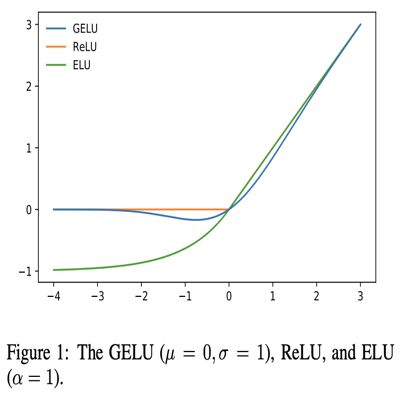

In [36]:
# GELU Activation functions
Image.open("C:\\Users\\user\\OneDrive\\사진\\GELU_activation_functions.png").resize((400,400))

In [37]:
# softmax to get max_prob for next prediction 
def softmax(x, axis= -1): 
    x = x - reduce_max(x, axis=axis, keepdims=True)
    ex = torch.exp(x)
    return ex / tf.reduce_sum(ex, axis=axis, keepdims=True)

# GELU activation w/ tanh (Not ReLU)
def gelu(x):
    return 0.5*x*(1+torch.tanh(math.sqrt(2/math.pi)*(x+0.044715*torch.pow(x,3))))

# normalization 
def norm(x, scope, *, axis=-1, epsilon=1e-5):
    # Normalize to mean=0, std=1, then do a diagonal affine transform 
    with tf.variable_scope(scope):
        n_state = x.shape[-1].value
        g = tf.get_variable('g', [n_state], initializer=tf.constant_initializer(1))
        b = tf.get_variable('b', [n_state], initializer=tf.constant_initializer(0))
        u = tf.reduce_mean(x, axis=axis, keepdims=True)
        s = tf.reduce_mean(tf.square(x-u), axis=axis, keepdims=True)
        x = (x-u)*tf.rsqrt(s+epsilon)
        x = x*g+b 
        return x 


In [38]:
def split_states(x, n):
    """Reshape the last dimension of x into [n, x.shape[-1]/n]."""
    *start, m = shape_list(x)
    return tf.reshape(x, start + [n, m//n])

def merge_states(x):
    """Smash the last two dimensions of x into a single dimension."""
    *start, a, b = shape_list(x)
    return tf.reshape(x, start + [a*b])

def conv1d(x, scope, nf, *, w_init_stdev=0.02):
    with tf.variable_scope(scope):
        *start, nx = shape_list(x)
        w = tf.get_variable('w', [1, nx, nf], initializer=tf.random_normal_initializer(stddev=w_init_stdev))
        b = tf.get_variable('b', [nf], initializer=tf.constant_initializer(0))
        c = tf.reshape(tf.matmul(tf.reshape(x, [-1, nx]), tf.reshape(w, [-1, nf]))+b, start+[nf])
        return c


In [39]:
# Masked Attention 
def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.

    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

In [40]:
# ATTENTION BLOCK!!! 
def attn(x, scope, n_state, *, past, hparams):
    assert x.shape.ndims == 3  # Should be [batch, sequence, features]
    assert n_state % hparams.n_head == 0
    if past is not None:
        assert past.shape.ndims == 5  # Should be [batch, 2, heads, sequence, features], where 2 is [k, v]

    def split_heads(x):
        # From [batch, sequence, features] to [batch, heads, sequence, features]
        return tf.transpose(split_states(x, hparams.n_head), [0, 2, 1, 3])

    def merge_heads(x):
        # Reverse of split_heads
        return merge_states(tf.transpose(x, [0, 2, 1, 3]))

    def mask_attn_weights(w):
        # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
        _, _, nd, ns = shape_list(w)
        b = attention_mask(nd, ns, dtype=w.dtype)
        b = tf.reshape(b, [1, 1, nd, ns])
        w = w*b - tf.cast(1e10, w.dtype)*(1-b)
        return w

    # multihead_attention: use multi attention blocks 
    def multihead_attn(q, k, v):
        # q, k, v have shape [batch, heads, sequence, features]
        w = tf.matmul(q, k, transpose_b=True)
        w = w * tf.rsqrt(tf.cast(v.shape[-1].value, w.dtype))

        w = mask_attn_weights(w)
        w = softmax(w)
        a = tf.matmul(w, v)
        return a

    with tf.variable_scope(scope):
        c = conv1d(x, 'c_attn', n_state*3)
        q, k, v = map(split_heads, tf.split(c, 3, axis=2))
        present = tf.stack([k, v], axis=1)
        if past is not None:
            pk, pv = tf.unstack(past, axis=1)
            k = tf.concat([pk, k], axis=-2)
            v = tf.concat([pv, v], axis=-2)
        a = multihead_attn(q, k, v)
        a = merge_heads(a)
        a = conv1d(a, 'c_proj', n_state)
        return a, present



In [41]:
# BERT, GPT: uses 2-layer MLP with GELU(Gaussian Error Linear Unit) activation
def mlp(x, scope, n_state, *, hparams):
    with tf.variable_scope(scope):
        nx = x.shape[-1].value
        h = gelu(conv1d(x, 'c_fc', n_state))
        h2 = conv1d(h, 'c_proj', nx)
        return h2


def block(x, scope, *, past, hparams):
    with tf.variable_scope(scope):
        nx = x.shape[-1].value
        a, present = attn(norm(x, 'ln_1'), 'attn', nx, past=past, hparams=hparams)
        x = x + a
        m = mlp(norm(x, 'ln_2'), 'mlp', nx*4, hparams=hparams)
        x = x + m
        return x, present

def past_shape(*, hparams, batch_size=None, sequence=None):
    return [batch_size, hparams.n_layer, 2, hparams.n_head, sequence, hparams.n_embd // hparams.n_head]

def expand_tile(value, size):
    """Add a new axis of given size."""
    value = tf.convert_to_tensor(value, name='value')
    ndims = value.shape.ndims
    return tf.tile(tf.expand_dims(value, axis=0), [size] + [1]*ndims)

def positions_for(tokens, past_length):
    batch_size = tf.shape(tokens)[0]
    nsteps = tf.shape(tokens)[1]
    return expand_tile(past_length + tf.range(nsteps), batch_size)



In [42]:
# Overall Model
def model(hparams, X, past=None, scope='model', reuse=False):
    with tf.variable_scope(scope, reuse=reuse):
        results = {}
        batch, sequence = shape_list(X)

        wpe = tf.get_variable('wpe', [hparams.n_ctx, hparams.n_embd],
                             initializer=tf.random_normal_initializer(stddev=0.01))
        wte = tf.get_variable('wte', [hparams.n_vocab, hparams.n_embd],
                             initializer=tf.random_normal_initializer(stddev=0.02))
        past_length = 0 if past is None else tf.shape(past)[-2]
        h = tf.gather(wte, X) + tf.gather(wpe, positions_for(X, past_length))

        # Transformer
        presents = []
        pasts = tf.unstack(past, axis=1) if past is not None else [None] * hparams.n_layer
        assert len(pasts) == hparams.n_layer
        for layer, past in enumerate(pasts):
            h, present = block(h, 'h%d' % layer, past=past, hparams=hparams)
            presents.append(present)
        results['present'] = tf.stack(presents, axis=1)
        h = norm(h, 'ln_f')

        # Language model loss.  Do tokens <n predict token n?
        h_flat = tf.reshape(h, [batch*sequence, hparams.n_embd])
        logits = tf.matmul(h_flat, wte, transpose_b=True)
        logits = tf.reshape(logits, [batch, sequence, hparams.n_vocab])
        results['logits'] = logits
        return results